# Homework 03 — IANNwTF
## Group 27
Deadline: Nov 14, 2021 23:59

<https://forms.gle/8qwiuUXCfLjKGeg67>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.size'] = 15

## Data set
Load the data set using 100.000 examples for training and 1000 for testing

Prepare the data
* convert strings to one-hot-vectors for encoding the nucleotides (A, C, G, T)
* one-hot encode the labels

In [2]:
import tensorflow_datasets as tfds
train_ds, test_ds = tfds.load('genomics_ood', split = ['train[:100000]', 'test[:1000]'], as_supervised = True)

# helper function to create one-hot-vectors for encoding the nucleotides (A, C, G, T)
def onehotify(tensor):
    vocab ={'A':'1', 'C': '2', 'G':'3', 'T':'0'}
    for key in vocab.keys():
        tensor = tf.strings.regex_replace(tensor, key, vocab[key])
        split = tf.strings.bytes_split(tensor)
        labels = tf.cast(tf.strings.to_number(split), tf.uint8)
        onehot = tf.one_hot(labels, 4)
        onehot = tf.reshape(onehot, (-1,))
    return onehot

train_ds = train_ds.map(lambda x, y: (onehotify(x), tf.one_hot(y, 10)))
test_ds = test_ds.map(lambda x, y: (onehotify(x), tf.one_hot(y, 10)))

train_dataset = train_ds.batch(128)
train_dataset = train_dataset.shuffle(buffer_size=128)

test_dataset = test_ds.batch(128)

## Model
A simple fully connected feed forward neural network with the following layers:

* Hidden layer 1:  256 units, with sigmoid activation function
* Hidden layer 2:  256 units, with sigmoid activation function. 
* Output:  10 units.  With softmax activation function

In [3]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Layer):
    
    def __init__(self):
        super(Model, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.output_layer = tf.keras.layers.Dense(units=10,
                                               activation=tf.keras.activations.softmax
                                               )
        
    def call(self, x):

        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x

## Train and test functions

In [4]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 

def test(model, test_data, loss_function):
    test_accuracy_aggregator = []
    test_loss_aggregator = []
    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.sum(np.argmax(target, axis=1) == np.argmax(prediction, axis=1))/target.shape[0]
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(sample_test_accuracy)
    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)
    
    return test_loss, test_accuracy

## Training and visualisation

In [5]:
tf.keras.backend.clear_session()

# hyperparameters
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.95

# initialize the model
model = Model()
# initialize loss function: categorical cross entropy
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# save data for visualising later
train_losses = []

test_losses = []
test_accuracies = []

# loss and accuracy before training
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# loss on the training data before training
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# train for num_epochs epochs
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9


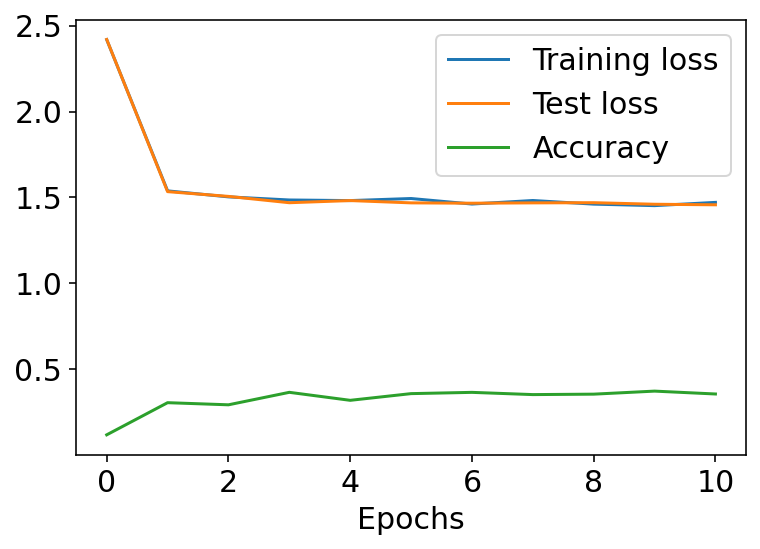

In [6]:
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Epochs")
plt.legend((line1,line2,line3),("Training loss","Test loss", "Accuracy"))
plt.show()